In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#1. SETUP AND DATA CLEANING
#Load the Dataset
df = pd.read_csv('data/WA_Fn-UseC_-Telco-Customer-Churn.csv')

#Data Cleaning
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())

#Convert 'Churn' to binary for easier analysis
df['Churn'] = df['Churn'].apply(lambda x:1 if x =='Yes' else 0)

#Drop customer ID as it is irrelevant for prediction
df.drop('customerID', axis=1, inplace=True)

print(f"Dataset Shape: {df.shape}")
print(df.info())

Dataset Shape: (7043, 20)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod   

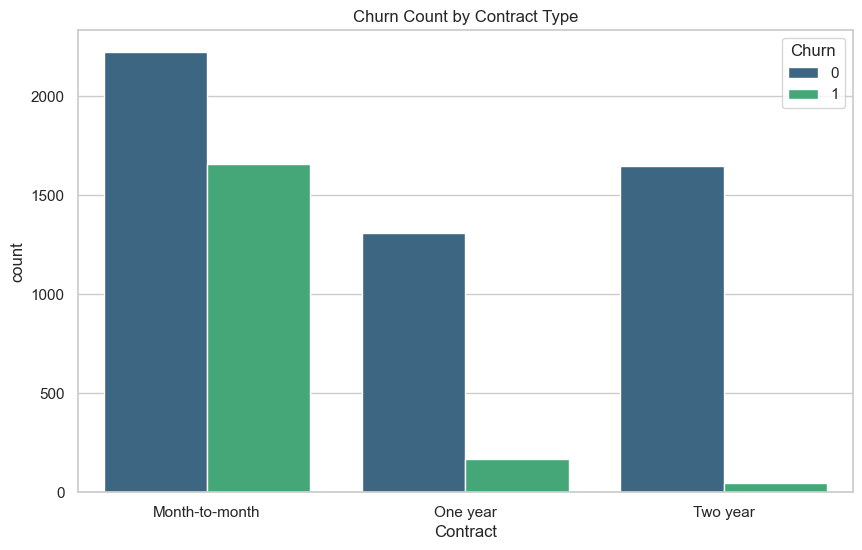

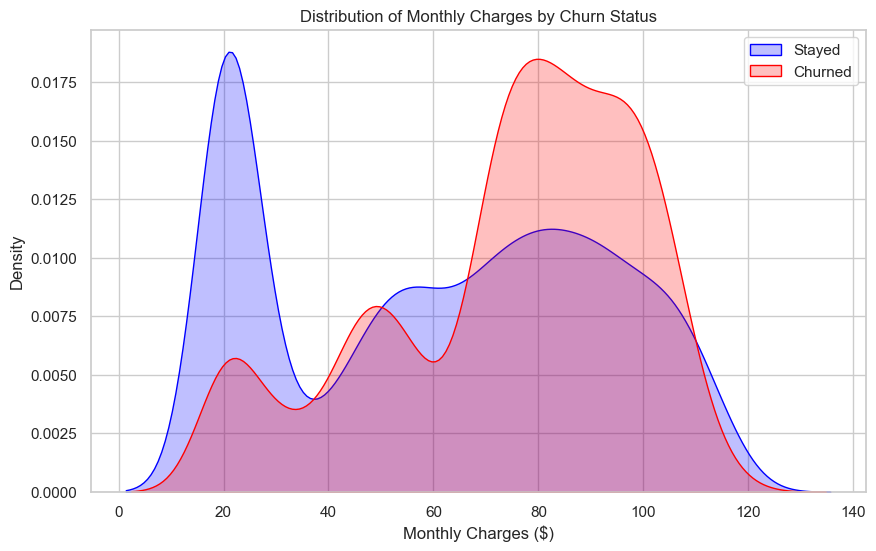

In [3]:
#2. EDA
#Set the visual style
sns.set_theme(style='whitegrid')

#Visual 1: Churn by Contract Type (Crucial Business Insight)
plt.figure(figsize=(10,6))
sns.countplot(x='Contract', hue='Churn', data=df, palette='viridis')
plt.title('Churn Count by Contract Type')
plt.show()

#Visual 2: Monthly Charges vs Churn
plt.figure(figsize=(10,6))
sns.kdeplot(df[df['Churn'] ==0]['MonthlyCharges'], fill=True, label='Stayed', color='blue')
sns.kdeplot(df[df['Churn'] ==1]['MonthlyCharges'], fill=True, label='Churned', color='red')
plt.title('Distribution of Monthly Charges by Churn Status')
plt.xlabel('Monthly Charges ($)')
plt.legend()
plt.show()


In [4]:
#3. FEATURE ENGINEERING
#Create feature for 'Total Services' subscribed
service_cols = ['PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
                'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

#Count total services they have
df['TotalServices'] = (df[service_cols] != 'No').sum(axis=1)

#Check correlation of new feature with Churn
print(df[['TotalServices','Churn']].corr())

               TotalServices    Churn
TotalServices        1.00000 -0.32314
Churn               -0.32314  1.00000


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE

In [6]:
#4. Prepare Data for Machine Learning
#Convert categorical variables into numerical features
df_ml = pd.get_dummies(df, drop_first=True)

#Define features X and target y
X = df_ml.drop('Churn', axis=1)
y = df_ml['Churn']

#5. Train-Test Split
#Keep 20% of the data hidden to test how the model performs on "new" customers
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#6. Handle Class Imbalance with SMOTE
#This creates synthetic examples of the "Churn" class so the model doesn't ignore them
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

print(f"Original training shape: {X_train.shape}")
print(f"Resampled training shape: {X_train_res.shape}")


Original training shape: (5634, 31)
Resampled training shape: (8278, 31)


In [7]:
#7. Scaling Numerical Features
scaler = StandardScaler()
X_train_res = scaler.fit_transform(X_train_res)
X_test = scaler.transform(X_test)

#8. Model Training
#Random Forest handles non-linear relationships well
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_res, y_train_res)

#9. Evaluation
y_pred = model.predict(X_test)

print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred))

print(f"ROC_AUC Score: {roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]):.2f}")


--- Classification Report ---
              precision    recall  f1-score   support

           0       0.85      0.85      0.85      1035
           1       0.58      0.58      0.58       374

    accuracy                           0.78      1409
   macro avg       0.71      0.71      0.71      1409
weighted avg       0.78      0.78      0.78      1409

ROC_AUC Score: 0.82


/var/folders/cg/mb6209w970d35dlcc1lc8k240000gn/T/ipykernel_888/578975717.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='magma')


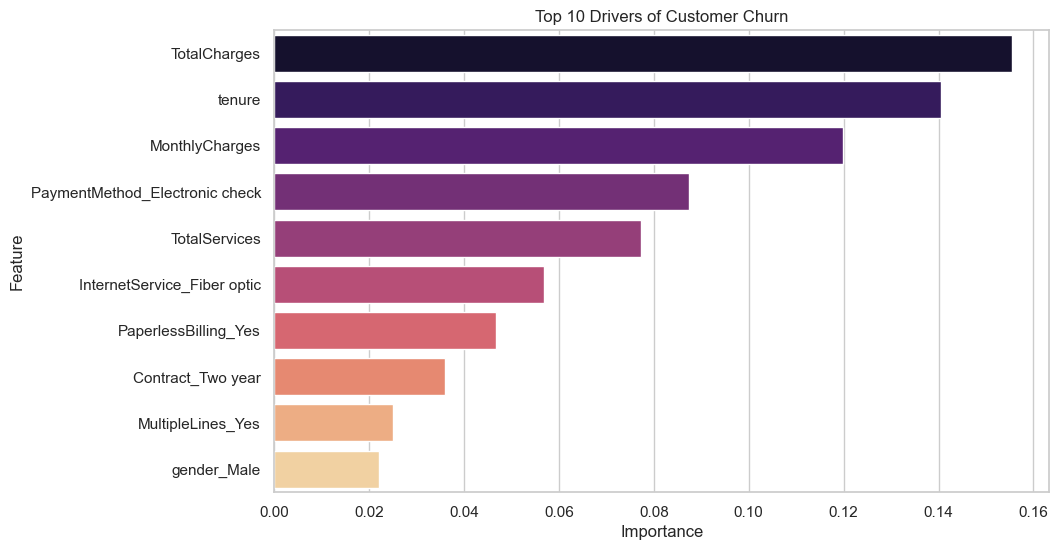

In [8]:
#10. Visualize Feature Importance
importances = model.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False).head(10)

plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='magma')
plt.title('Top 10 Drivers of Customer Churn')
plt.show()

In [9]:
import joblib

# 1. Save the trained model
joblib.dump(model, 'churn_model.pkl')

# 2. Save the scaler (Crucial! Your app needs this to normalize user input)
joblib.dump(scaler, 'scaler.pkl')

# 3. Save the list of feature names 
# This ensures the app sends columns to the model in the correct order
feature_names = X.columns.tolist()
joblib.dump(feature_names, 'feature_names.pkl')

print("Model, Scaler, and Feature names saved successfully!")

Model, Scaler, and Feature names saved successfully!
